# Pull Data

Grabbing WebIDs ...
WebID collection complete!
15:19:43: Sending API request... Chunk 1 of 1
15:19:44: Response recieved for 1 tags! (0.86)
Grabbing WebIDs ...
WebID collection complete!
15:19:44: Sending API request... Chunk 1 of 1
15:19:45: Response recieved for 1 tags! (1.03)


Text(0, 0.5, 'Electricity')

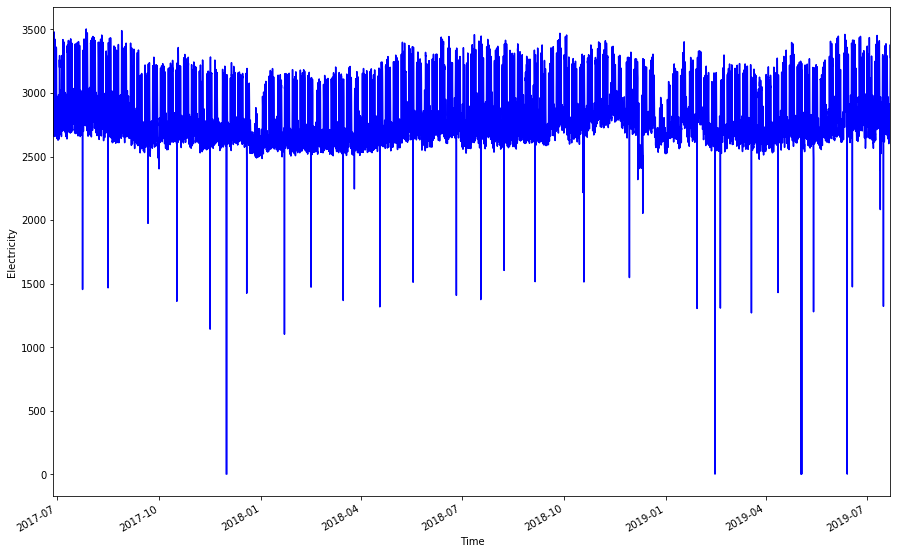

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df2 = pc.get_stream_by_point(second_points, start = start, end = end, calculation=calculation, interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series.replace(np.nan, 0, inplace=True)
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")

# Agglomerative Clustering: 1D 

Text(0, 0.5, 'Electricity')

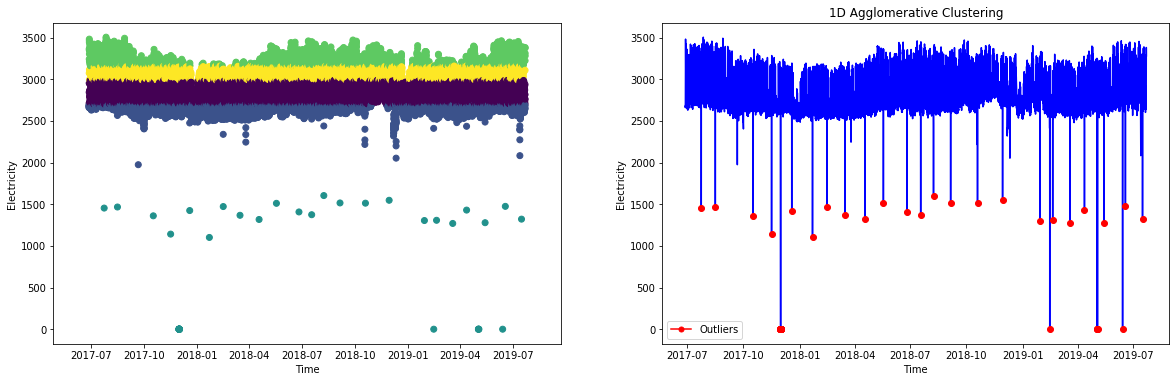

In [4]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib.lines import Line2D


#retrieve electricity data
X = np.array(series.values).reshape(-1, 1)
#fit clustering algo
agg_cluster = AgglomerativeClustering(n_clusters = 5)
#fit to data
agg_cluster.fit(X)
labels = agg_cluster.labels_
#plot for clusters, plot for outliers
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
x = series.index
y = series.values
plt.scatter(x, y, c=labels, cmap='viridis') 
plt.xlabel("Time")
plt.ylabel("Electricity")
#own df
agg_df = pd.DataFrame(dict(x = range(len(series)), y = series.values, labels = labels))
#retrieve outlier cluster, which is the cluster with the lowest mean
counts = agg_df.groupby(['labels'])['y'].mean()
counts = counts.sort_values(ascending=True)
outlier_cluster = counts.index[0]
agg_df = agg_df.loc[agg_df['labels'] == outlier_cluster]
#retrieve outliers
outliers = agg_df['y'].tolist()
outlier_indexes  = agg_df.index.tolist()
plt.subplot(2, 2, 2)
plt.plot(x, y, color = "blue")
for index in outlier_indexes:
    outlier = series.values.tolist()[index]
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = "red", marker = "o")
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers', markersize=5)]
plt.legend(handles=legend_elements, loc='best')
plt.title("1D Agglomerative Clustering")
plt.xlabel("Time")
plt.ylabel("Electricity")




# DBSCAN Clustering

If a point gets assigned -1 as a label, it is classified as an outlier.
Initial Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0]
Estimated number of clusters: 20


Text(0.5, 1.0, 'Data Without Outliers')

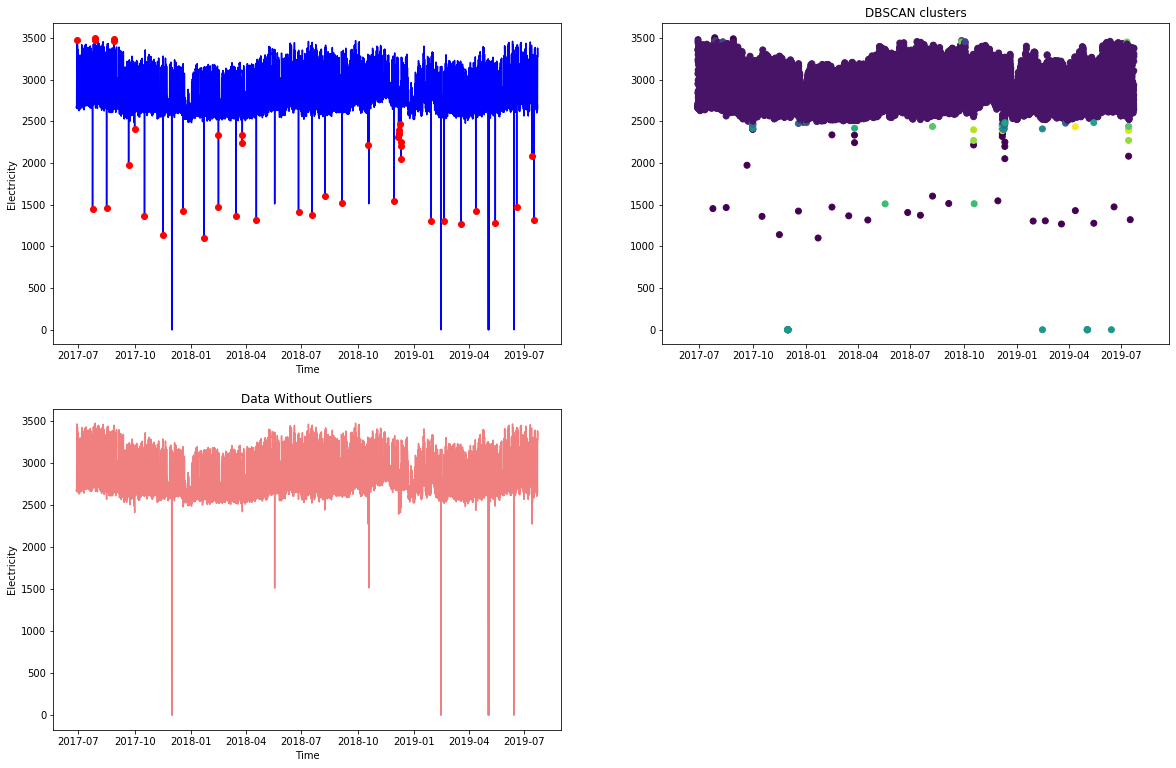

In [9]:
from sklearn.cluster import DBSCAN

#lower eps = lower threshold for outliers, higher eps = higher threshold for outliers
x = np.array(series.values).reshape(-1, 1)
clustering = DBSCAN(eps=2, min_samples=2).fit(x)
indexes = []
for i in range(len(clustering.labels_)):
    label = clustering.labels_[i]
    #label is -1 = noise = outlier
    if label == -1:
        indexes.append(i)
print("If a point gets assigned -1 as a label, it is classified as an outlier.")
outliers = []
#plot outliers
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color = 'blue')
for index in indexes:
    outlier = series.values.tolist()[index]
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Electricity")


n_clusters_ = len(set(clustering.labels_))
print("Initial Labels:", clustering.labels_.tolist()[0:20])
print('Estimated number of clusters: %d' % n_clusters_)
#plot dbscan clusters
plt.subplot(2, 2, 2)
plt.scatter(series.index, series.values, c = clustering.labels_)
plt.title("DBSCAN clusters")
    
#plot data without outliers
plt.subplot(2, 2, 3)
non_outlier_indexes = [i for i in list(range(len(series))) if i not in indexes]
non_outlier_data = [series.values.tolist()[j] for j in non_outlier_indexes]
non_outlier_dates = [series.index[k] for k in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data, color = 'lightcoral')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Data Without Outliers")    
    
    
#eps=2 the distance between them needs to be <=2 to be considered part of a cluster and not noise
#this is a low threshold for outliers since many points will not be this close together and thus will be counted as noise
#eps=5 the distance between them needs to be <=5 to be considered part of a cluster and not noise
#this is a higher threshold for outliers since fewer points will be outside this distance than 2


# 2D Aggo Clustering (Using Outside Air Temp)

In [ ]:
#this function extracts points that are x SD outside of the cluster (outside air temperature)
#this extracts outliers that are associated with differing air temps even if not obvious outliers in the 1d series
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.lines import Line2D
import random
#use outside air temperature as x
new_df = pd.merge_asof(df, df2, on = "Timestamp")
new_df = new_df.dropna()
#x = temperature
x = new_df.iloc[:, 2]
#y = electricity
y = new_df.iloc[:, 1]
#combined, new 2d data
data = new_df.iloc[:, [2, 1]]
agg_cluster = AgglomerativeClustering(n_clusters = 10)
#fit to data
agg_cluster.fit(data)
labels = agg_cluster.labels_
agg_df = pd.DataFrame(dict(x = x, y = y, labels = labels, Timestamp = new_df['Timestamp']))
#dummy column
agg_df['dummy'] = random.sample(range(1, 10000000), agg_df.shape[0])
fig = plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.scatter(x, y, c=labels, cmap='viridis') 
plt.xlabel("Outside Air Temp")
plt.ylabel("Electricity")
#extract outliers
unique_labels = np.unique(labels.tolist())
outliers = []
dummies = []

for label in unique_labels:
    #subset the df so that it only contains that cluster
    subsetted_df = agg_df.loc[agg_df['labels'] == label]
    #extract the threshold for that cluster
    #outside air temperature, just for that cluster
    t = subsetted_df['x'].tolist()
    upper_threshold = np.mean(t) + 2.5*np.std(t)
    lower_threshold = np.mean(t) - 2.5*np.std(t)
    m = list(range(subsetted_df.shape[0]))
    for i in m:
        point = subsetted_df['x'].tolist()[i]
        index = subsetted_df['x'].index.tolist()[i]
        dummy_point  = subsetted_df['dummy'].tolist()[i]
        if point > upper_threshold or point < lower_threshold:
            outliers.append(point)
            #use a dummy column since every outlier point is not unique, therefore when indexing 
            #the outlier later in the original data, we can use the dummy value associated with the outlier point first
            #otherwise we may have an outlier, say 70, that appears several times in the original data
            #then when extracting the index, it could extract the wrong index because 70 is not unique
            dummies.append(dummy_point)
    
#plot outliers      
plt.subplot(2, 2, 2)
plt.scatter(x, y, c = labels)
for dummy in dummies:
    #extract the index associated with the dummy outlier
    index = agg_df['dummy'].tolist().index(dummy)
    #use that to extract the outside air temperature outlier
    temp_outlier = agg_df['x'].tolist()[index]
    elec_outlier = agg_df['y'].tolist()[index]
    plt.plot(temp_outlier, elec_outlier, color = 'red', marker = 'o')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers',
                         markersize=5)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("Outside Air Temperature")
plt.ylabel("Electricity")

#plot data with outliers
plt.subplot(2, 2, 3)
plt.plot(agg_df['Timestamp'].tolist(), agg_df['y'].tolist())
for dummy in dummies:
    outlier_index = agg_df['dummy'].tolist().index(dummy)
    elec_outlier = agg_df['y'].tolist()[outlier_index]
    elec_date = new_df['Timestamp'].tolist()[outlier_index]
    plt.plot(elec_date, elec_outlier, c = 'red', marker = 'o')
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Data With Outliers")

#plot data with outliers removed, use dummy column
plt.subplot(2, 2, 4)
non_outlier_indexes = [i for i in list(range(agg_df.shape[0])) if agg_df['dummy'].tolist()[i] not in dummies]
non_outlier_data = [agg_df['y'].tolist()[i] for i in non_outlier_indexes]
non_outlier_dates = [agg_df['Timestamp'].tolist()[i] for i in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data, color = 'aquamarine' )
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Data Without Outliers")